,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,43000,26,60,31000,20,4.2,3.0,2.8,50
1,12000,7,20,38000,20,1.9,4.4,2.9,50
2,88000,50,20,69000,12,3.3,3.8,3.4,80
3,24000,50,60,26000,14,3.6,3.8,2.6,50
4,137000,24,60,43000,4,3.6,2.5,2.7,100


<Figure size 432x288 with 0 Axes>

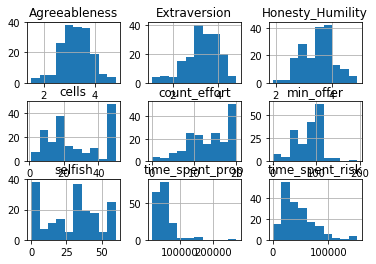

<Figure size 432x288 with 0 Axes>

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
df = df.dropna()
df = df.dropna()
df = df[['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]



#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

#x = range(0, len(df['prop']))
#x1 = df['min_offer']

#plt.plot(x, x1)

In [2]:
# sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('time_spent_prop', 'time_spent_risk'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

In [3]:
#manual ablation
#df = df.drop(columns=['cells','selfish','count_effort','Honesty_Humility','Extraversion','Agreeableness','time_spent_risk','time_spent_prop'])

In [4]:
from sklearn.linear_model import LinearRegression
# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
NB_FEATURES = x.shape[1]
NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
#print(xTrain)
#print(yTrain)

# regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

# print("Intercept:", regressor.intercept_)
# print("Coef:", regressor.coef_)

# yPredict = regressor.predict(xTest)
# print("R2:", r2_score(yTest, yPredict))

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
# #print(out_data)

# out_data.plot(figsize=(30,10))

In [5]:
@np.vectorize
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

@np.vectorize
def sigmoid1024(x):
    return (1024**x/(1024**x + 1))

@np.vectorize
def sigmoid128(x):
    return (128**x/(128**x + 1))

# @np.vectorize
# def loss(x):
#     x = (x+10) / 40
#     return (1 - (sigmoid1024(x) * np.cos(x/np.pi))) / 2
    
# @np.vectorize
# def gain(x):
#     return 2 - loss(x)

# @np.vectorize
def gain(x):
    x = (x - 16) / 40
    return (sigmoid1024(x) *  np.cos(x/np.pi))

@np.vectorize
def loss(x):
#     x_ = (x) / 40
#     x = (x + 32) / 40
#     return (1 - sigmoid1024(x) *  np.cos(x_/np.pi))
    return 1 - gain(x+32)

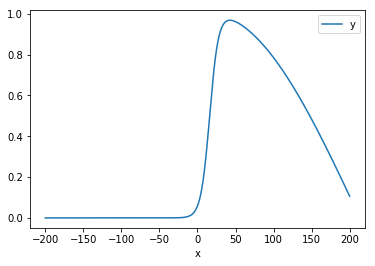

In [6]:
x = np.linspace(-200, 200, 1000)
y = gain(x)

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

Min value:  10.610610610610621


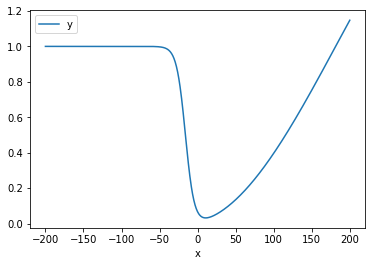

In [7]:
y = loss(x)
print("Min value: ", x[y.argmin()])

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

In [34]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES):
        self.size = size
        self.nb_features = nb_features
    
    def fit_predict(self, xTrain, yTrain, size=None, distance=5, upsample=True):
        size = size or self.size or len(xTrain) * 4
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        if upsample:
            targets, counts = np.unique(yTrain, return_counts=True)
            #NOTE: ignore targets with onlyo one smaple 
            #counts[counts==1] = 0
            probs = (1 - counts/counts.sum())**2
            probs[counts==1] = probs.min()
            probs /= probs.sum()
        else:
            targets = yTrain.ravel()
            probs = None
        xRes = list(xTrain)
        yRes = list(yTrain.ravel())
        for _ in range(size):
            target = np.random.choice(targets, p=probs)
            target_mask = (yTrain.ravel()<=target) & (yTrain.ravel()>=(target-distance))
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = int(np.random.randint(self.nb_features))
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        return np.array(xRes), np.array(yRes)

    def fit_resample(self, xTrain, yTrain, size=None, distance=5):
        return self.fit_predict(xTrain, yTrain, size=size, distance=distance)

In [35]:
da = DACombine()
aX, aY = da.fit_predict(xTrain, yTrain, size=2048)
# pd.DataFrame(data=xTrain).hist()
# pd.DataFrame(data=aX).hist()
# items = np.arange(11)
# items[:4]
# items[items[:4]]
#aX.std(axis=0)
aY

array([50., 90., 35., ..., 50., 20., 95.])

In [10]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid128_tf(x):
    return (128**x) / (128**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    denum = tf.constant(40.0)
    x = tf.math.subtract(y_true, y_pred) - tf.constant(16.0)
    x = tf.math.truediv(x, denum)
    left_mul = sigmoid128_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)

def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(40.0)
    x0 = tf.math.subtract(y_true, y_pred) + tf.constant(32.0)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid128_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return K.mean(0.5 * (tf.math.subtract(one, tf.math.multiply(left_mul, right_mul))))

def loss2_tf(y_true, y_pred):
    l = 1 - gain_tf(y_true, y_pred)
    return 100*l

def gain2_tf(y_true, y_pred):
    g = 100 - loss2_tf(y_true, y_pred)
    return g

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: mse)
    """
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mae"]
    drop_rate = 0.0
    model = Sequential()
    model.add(Dense(32, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(drop_rate))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

Using TensorFlow backend.


**Model: No data Augmentation**

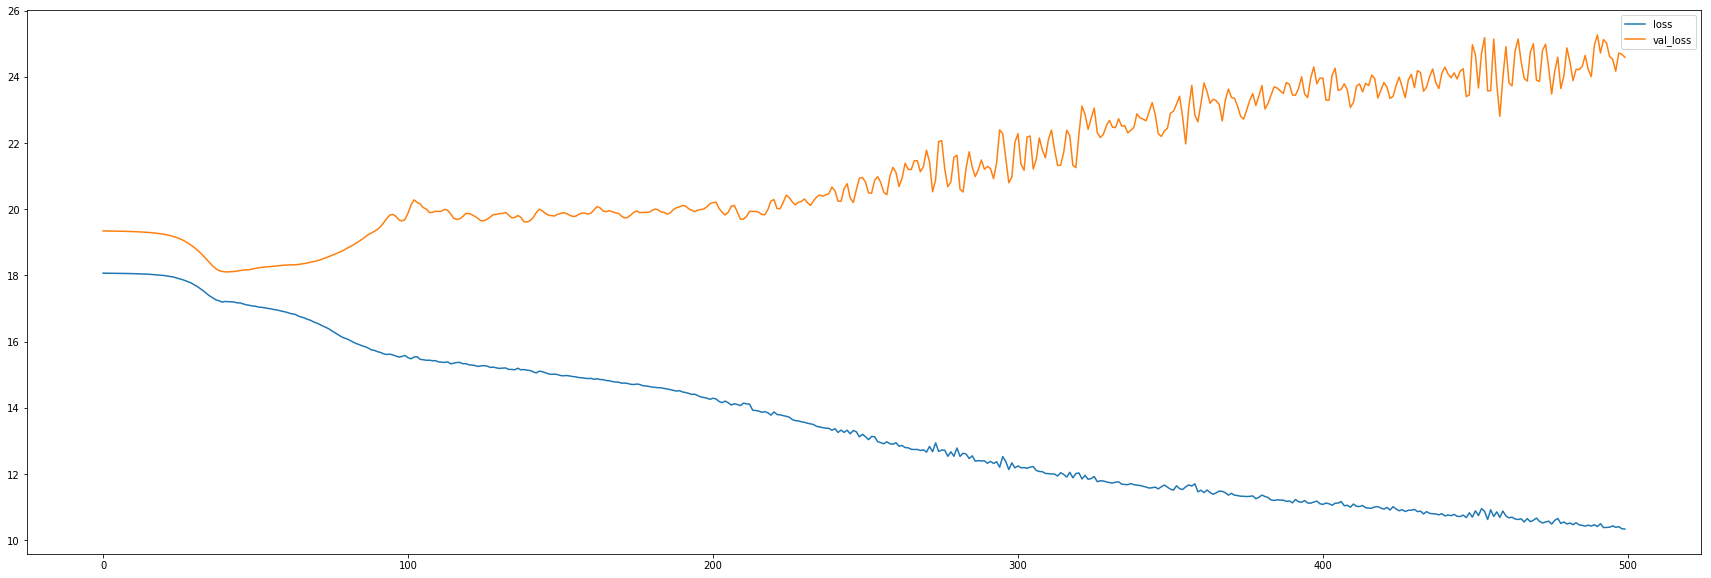

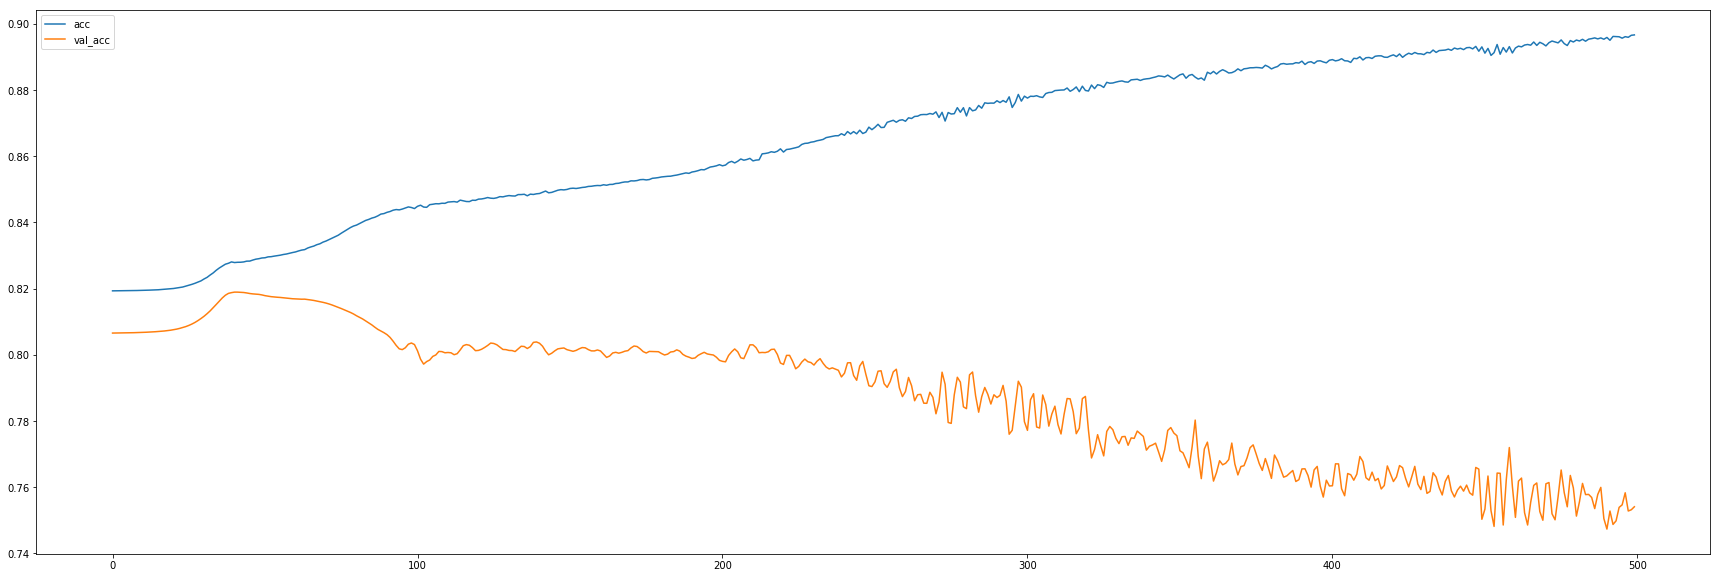

In [42]:
#sci-kit like training
model = keras_model(loss=loss2_tf, metrics=[gain_tf])
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_split=1/4, epochs=500, batch_size=60, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(figsize=(30,10))

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(figsize=(30, 10))

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
stl = sm.score(xTest, yTest, verbose=0)

**Model with data augmentation**

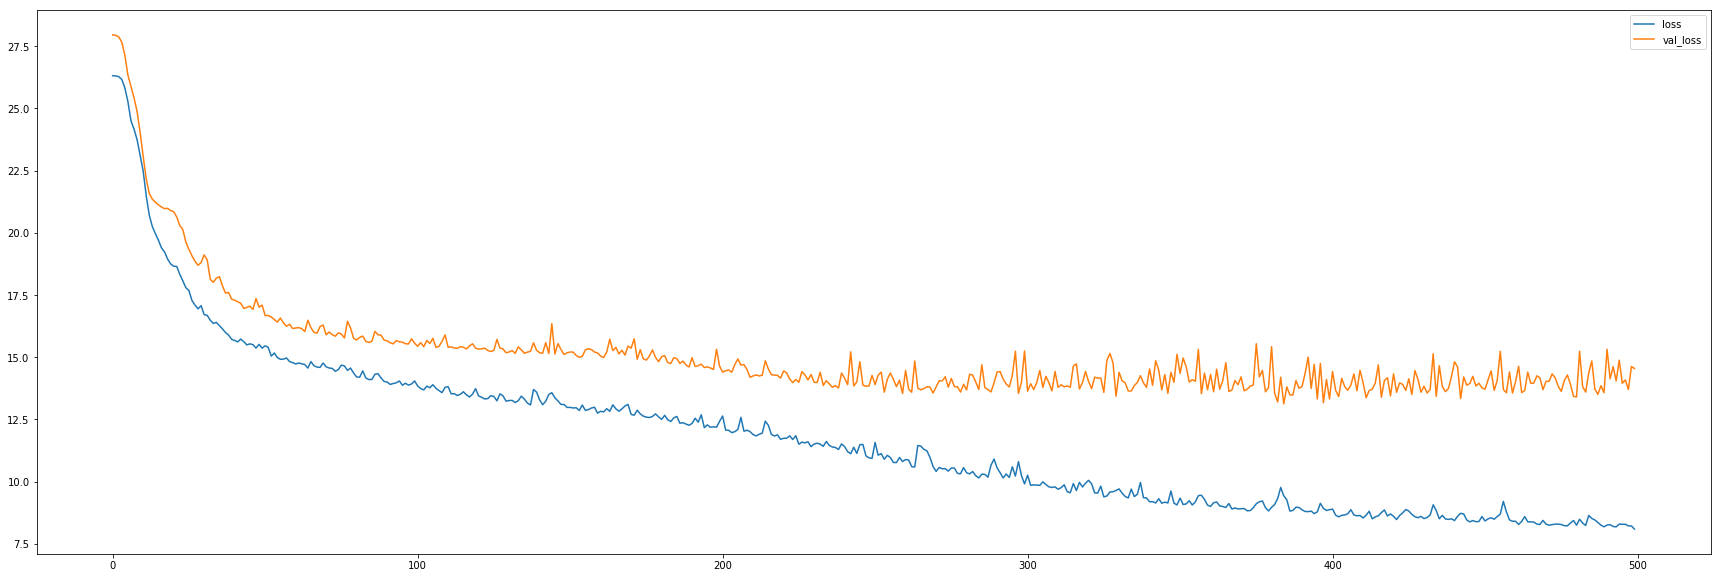

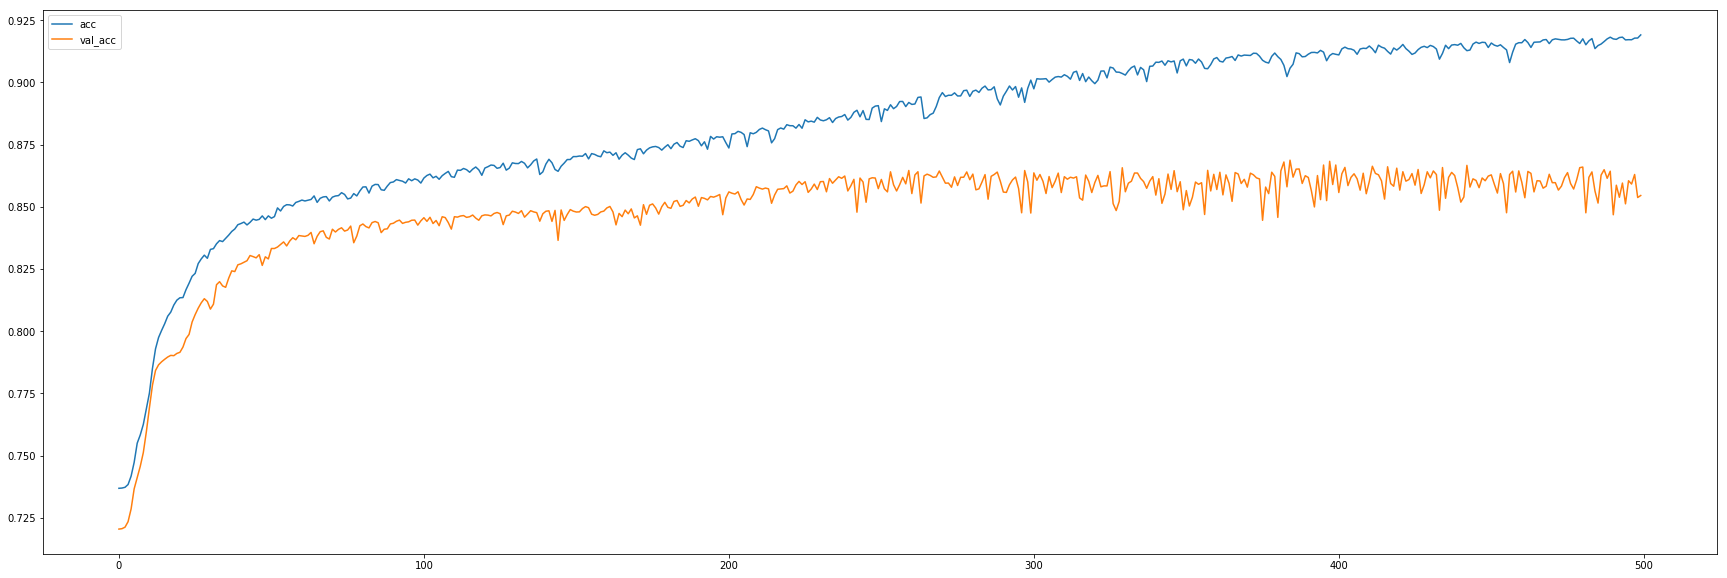

In [43]:
#sci-kit like training
model = keras_model(loss=loss2_tf, metrics=[gain_tf])
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_split=1/4, epochs=500, batch_size=60, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(figsize=(30,10))

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(figsize=(30, 10))

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
stl = sm.score(xTest, yTest, verbose=0)

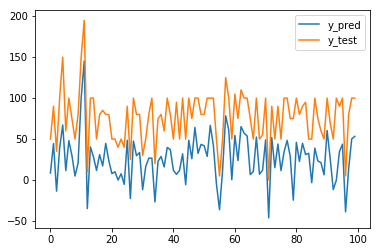

In [45]:
from sklearn.metrics import mean_squared_error as mse
yPred = model.predict(xTrain_a)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTrain_a), 'y_pred': np.ravel(yPred)})
out_data = out_data.head(100)
out_data.plot()

In [46]:
loss_baseline = "mse"
MAX_GAIN = 200.0

def gain2(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def gain_mean2(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res.mean()

In [49]:
yPred = model.predict(xTest)

In [50]:
gain_mean2(yTest.ravel(), yPred.ravel())

7.537513